In [1]:
import collections
import copy
import itertools
import json
import datetime
import random
import time


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

In [2]:
with open("data/results/all__post_stats.json") as handle:
    post_stats = json.load(handle)
    sorted_post_stats = sorted(post_stats, key=lambda item:  datetime.datetime.strptime(item['date'], "%Y-%m-%dT%H:%M:%S.%f"))

with open("data/results/ip__libs_first_dates.json") as handle:
    libs_first_dates = json.load(handle)

In [3]:
def get_randomized_post_stats(sorted_post_stats):

    libs_already_available = []
    randomized_post_stats = []
    
    randomized_pairs_first_dates = {}
    randomized_pairs_dates = collections.defaultdict(list)
    
    for stat in tqdm.tqdm(sorted_post_stats):
        randomized_stat = copy.deepcopy(stat)
        imports = stat["imports"]
        randomized_stat["imports"] = []
    
        vintages = []
        for imp in imports:
            if libs_first_dates[imp]["id"] == stat["id"]:
                vintages.append(imp)
                randomized_stat["imports"].append(imp)
            else:
                randomized_stat["imports"].append(random.choice(libs_already_available))
        libs_already_available.extend(vintages)
        randomized_post_stats.append(randomized_stat)
    
        # Artificially generate pairs_first_dates
        for imp1, imp2 in itertools.combinations(randomized_stat["imports"], 2):
            canonical = "|".join(sorted([imp1, imp2]))
            stat_date_str = datetime.datetime.strptime(stat["date"], "%Y-%m-%dT%H:%M:%S.%f").strftime("%Y-%m-%d")
            
            randomized_pairs_dates[canonical].append(stat_date_str)
            if canonical in randomized_pairs_first_dates:
                continue
            randomized_pairs_first_dates[canonical] = {
                "id": stat["id"],
                "poster_id": stat["poster_id"],
                "date": stat_date_str,
            }
    assert len(sorted_post_stats) == len(randomized_post_stats)
    return randomized_post_stats, randomized_pairs_first_dates, randomized_pairs_dates


In [15]:
VALUE_THRESHOLDS = [2, 5]#[5, 10, 25]#[25, 50, 100, 200]
VALUE_TIME_WINDOW = datetime.timedelta(days=365)
BIN_BORDERS = [1, 10, 25, 50, 100, 200, np.infty]  

def calculate_post_rank_distribution(sorted_post_stats, pairs_first_dates, pairs_dates):
    user_posts = collections.defaultdict(set)
    novel_post_stats = []
    post_rank_count = collections.defaultdict(int)
    novel_post_rank_count = collections.defaultdict(int)
    valuable_novel_post_rank_count = {
        k: collections.defaultdict(int) for k in VALUE_THRESHOLDS
    }
    stats = collections.defaultdict(int)
    for post_stat in tqdm.tqdm(sorted_post_stats):
        try:
            user_posts[post_stat["poster_id"]].add(post_stat["id"])
            post_rank = len(user_posts[post_stat["poster_id"]])
            novelty_count = 0
            is_valuable = {k: False for k in VALUE_THRESHOLDS}
            for imp1, imp2 in itertools.combinations(post_stat["imports"], 2):
                canonical_pair_name = "|".join(sorted([imp1, imp2]))
                if pairs_first_dates[canonical_pair_name]["id"] == post_stat["id"]:
                    novelty_count += 1
                    for value_threshold in VALUE_THRESHOLDS:
                        # Decide if the pair in the post received enough traction within the prescribed time window.
                        relevant_dates = [
                            dt for dt in pairs_dates[canonical_pair_name]if (
                                datetime.datetime.strptime(dt, "%Y-%m-%d") <
                                datetime.datetime.strptime(pairs_first_dates[canonical_pair_name]["date"], "%Y-%m-%d") + VALUE_TIME_WINDOW
                            )
                        ]
                        if len(relevant_dates) >= value_threshold:
                            is_valuable[value_threshold] = True
                    novel_post_stats.append(
                        {
                            "poster_id": post_stat["poster_id"],
                            "id": post_stat["id"],
                            "post_rank": len(user_posts[post_stat["poster_id"]]),
                            "canonical_pair_name": canonical_pair_name,
                            "pair_total_use_within_window": len(relevant_dates),
                            "date": datetime.datetime.strptime(post_stat["date"], "%Y-%m-%dT%H:%M:%S.%f"),
                        }
                    )
            if novelty_count > 0:
                stats["novelty_post_count"] += 1
                novel_post_rank_count[post_rank] += 1
    
                # Decide if the post is valuable
                for value_threshold in VALUE_THRESHOLDS:
                    if is_valuable[value_threshold]:
                        valuable_novel_post_rank_count[value_threshold][post_rank] += 1
            else:
                stats["non_novel_post_count"] += 1
            stats["total_post_count"] += 1
            post_rank_count[post_rank] += 1
        except Exception as exc:
            stats[exc] += 1
    
    print("STATS:")
    for k, v in stats.items():
        print(f"\t{k}: {v}")

    return post_rank_count, novel_post_rank_count, valuable_novel_post_rank_count

def calculate_novel_ratios(post_rank_count, novel_post_rank_count, valuable_novel_post_rank_count):
    # Calculate it for the richest domain of the valuable ratios, that is, for the smallest threshold.
    novel_ratio = {
        k: novel_post_rank_count.get(k, 0) / post_rank_count.get(k, 1)
        for k in sorted(valuable_novel_post_rank_count[min(VALUE_THRESHOLDS)].keys())
    }
    
    valuable_novel_ratio = {}
    for value_threshold in VALUE_THRESHOLDS:
        valuable_novel_ratio[value_threshold] = {
            k: valuable_novel_post_rank_count[value_threshold].get(k, 0) / post_rank_count.get(k, 1)
            for k in sorted(valuable_novel_post_rank_count[value_threshold].keys())
        }

    return novel_ratio, valuable_novel_ratio

In [50]:
post_rank_counts, novel_post_rank_counts, valuable_novel_post_rank_counts = [], [], []
NUMBER_OF_EXPERIMENTS = 10
weight = 1 / NUMBER_OF_EXPERIMENTS

for index in range(NUMBER_OF_EXPERIMENTS):
    print(f"ROUND {index}")
    post_rank_count, novel_post_rank_count, valuable_novel_post_rank_count =\
        calculate_post_rank_distribution(*get_randomized_post_stats(sorted_post_stats))
   
    post_rank_counts.append(post_rank_count)
    novel_post_rank_counts.append(novel_post_rank_count)
    valuable_novel_post_rank_counts.append(valuable_novel_post_rank_count)

# PERFORM AVERAGING
avg_post_rank_count = collections.defaultdict(int)
avg_novel_post_rank_count = collections.defaultdict(int)
avg_valuable_novel_post_rank_count = {k: collections.defaultdict(int) for k in VALUE_THRESHOLDS}

for prc in post_rank_counts:
    for k, v in prc.items():
        avg_post_rank_count[k] += weight * v

for nprc in novel_post_rank_counts:
    for k, v in nprc.items():
        avg_novel_post_rank_count[k] += weight * v

for vnprc in valuable_novel_post_rank_counts:
    for threshold in VALUE_THRESHOLDS:
        for k, v in vnprc[threshold].items():
            avg_valuable_novel_post_rank_count[threshold][k] += weight * v

ROUND 0


100%|██████████████████████████████| 1469300/1469300 [01:19<00:00, 18434.42it/s]


STATS:
	novelty_post_count: 669306
	total_post_count: 1469300
	non_novel_post_count: 799994
ROUND 1


100%|██████████████████████████████| 1469300/1469300 [01:25<00:00, 17113.47it/s]


STATS:
	novelty_post_count: 669333
	total_post_count: 1469300
	non_novel_post_count: 799967
ROUND 2


100%|██████████████████████████████| 1469300/1469300 [01:25<00:00, 17262.69it/s]


STATS:
	novelty_post_count: 669330
	total_post_count: 1469300
	non_novel_post_count: 799970
ROUND 3


100%|██████████████████████████████| 1469300/1469300 [01:20<00:00, 18179.90it/s]


STATS:
	novelty_post_count: 669259
	total_post_count: 1469300
	non_novel_post_count: 800041
ROUND 4


100%|██████████████████████████████| 1469300/1469300 [01:21<00:00, 18026.63it/s]


STATS:
	novelty_post_count: 669241
	total_post_count: 1469300
	non_novel_post_count: 800059
ROUND 5


100%|██████████████████████████████| 1469300/1469300 [01:23<00:00, 17612.99it/s]


STATS:
	novelty_post_count: 669327
	total_post_count: 1469300
	non_novel_post_count: 799973
ROUND 6


100%|██████████████████████████████| 1469300/1469300 [01:26<00:00, 16969.79it/s]


STATS:
	novelty_post_count: 669250
	total_post_count: 1469300
	non_novel_post_count: 800050
ROUND 7


100%|██████████████████████████████| 1469300/1469300 [01:26<00:00, 16993.18it/s]


STATS:
	novelty_post_count: 669306
	total_post_count: 1469300
	non_novel_post_count: 799994
ROUND 8


100%|██████████████████████████████| 1469300/1469300 [01:36<00:00, 15233.02it/s]


STATS:
	novelty_post_count: 669307
	total_post_count: 1469300
	non_novel_post_count: 799993
ROUND 9


100%|██████████████████████████████| 1469300/1469300 [01:25<00:00, 17274.53it/s]


STATS:
	novelty_post_count: 669348
	total_post_count: 1469300
	non_novel_post_count: 799952


In [51]:
novel_ratio, valuable_novel_ratio =\
    calculate_novel_ratios(avg_post_rank_count, avg_novel_post_rank_count, avg_valuable_novel_post_rank_count)

Text(0, 0.5, 'Probability')

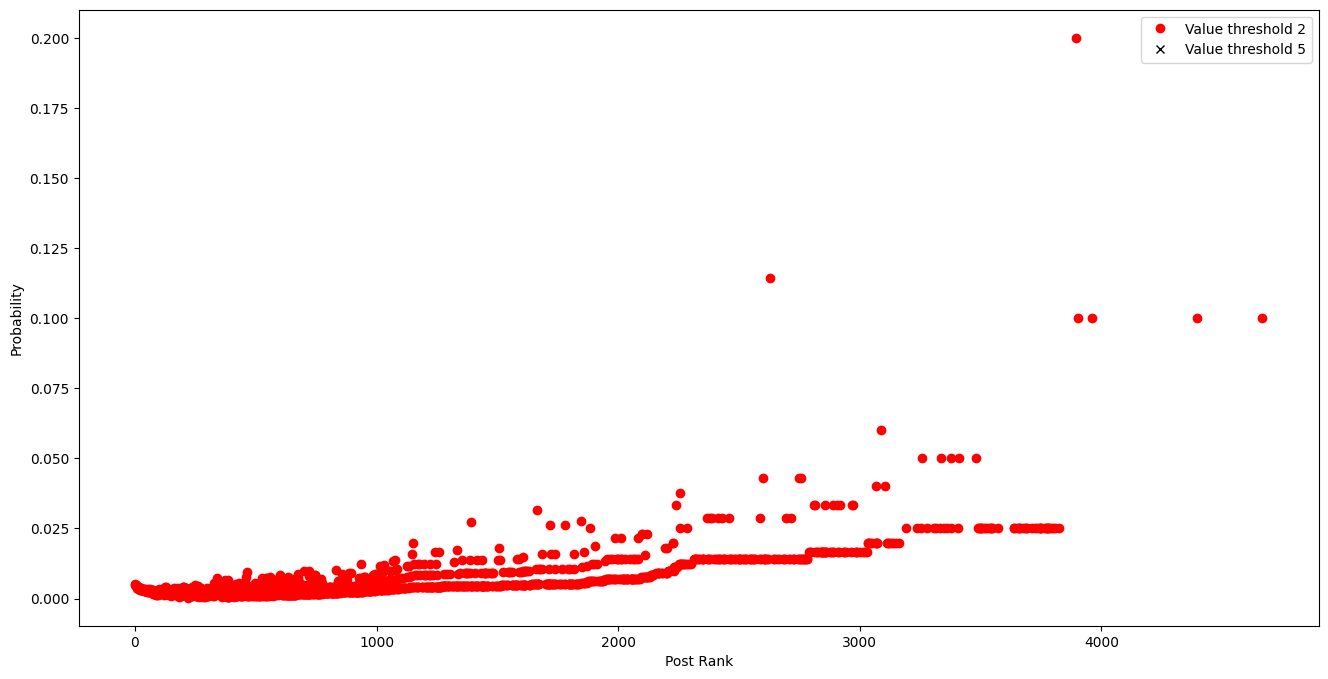

In [52]:
plt.figure(figsize=(16,8))
#plt.plot(sorted(novel_ratio.keys()), [novel_ratio[x] for x in sorted(novel_ratio.keys())], "b*", label="Novel Ratio")
forms = "ox^."
colors ="rkgm"
for index, value_threshold in enumerate(VALUE_THRESHOLDS):
    plt.plot(
        sorted(valuable_novel_ratio[value_threshold].keys()),
        [valuable_novel_ratio[value_threshold][x] for x in sorted(valuable_novel_ratio[value_threshold].keys())],
        f"{colors[index]}{forms[index]}", label=f"Value threshold {value_threshold}")
plt.legend()
plt.xlabel("Post Rank")
plt.ylabel("Probability")
#plt.ylim(0, .20)
#plt.semilogx()